# LogRatioEstimator_Ndim

First we need some imports.

In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
import dynesty

In [72]:
N = 10000  # Number of samples
z = np.random.rand(N, 3)*2 - 1

In [69]:
z = newv

In [73]:
r = (z[:,0]**2 + z[:,1]**2 + z[:,0]*z[:,1]*0.9)**0.5
x = r.reshape(N, 1) + np.random.randn(N, 1)*0.001

In [74]:
samples = swyft.Samples(x = x.astype(np.float32), z = z.astype(np.float32))

In [75]:
# z --> [z, sin(z), sin(2z), sin(4z), sin(8z), ...]
#2^(Lmax-1)

In [76]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        marginals = ((0, 1, 2),)
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 3, varnames = 'z')
        self.logratios2 = swyft.LogRatioEstimator_Ndim(num_features = 1, marginals = marginals,
                varnames = 'z', hidden_features = 128, num_blocks = 3, dropout = 0.0, Lmax = 8)

    def forward(self, A, B):
#        z = B['z']
        #zf = [z.unsqueeze(-1), torch.sin(z), torch.cos(z)]
        #zf = torch.cat(zf, dim=-1)
        #print(zf.shape)
        logratios1 = self.logratios1(A['x'], B['z'])
        logratios2 = self.logratios2(A['x'], B['z'])
        return logratios1, logratios2

In [77]:
trainer = swyft.SwyftTrainer(accelerator = 'cpu', devices=1, max_epochs = 5, precision = 32)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [78]:
dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.1, 0.1], num_workers = 0, batch_size = 256)

In [79]:
network = Network()

In [80]:
trainer.fit(network, dm)


  | Name       | Type                   | Params
------------------------------------------------------
0 | logratios1 | LogRatioEstimator_1dim | 52.2 K
1 | logratios2 | LogRatioEstimator_Ndim | 109 K 
------------------------------------------------------
161 K     Trainable params
0         Non-trainable params
161 K     Total params
0.647     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [81]:
x0 = 0.5

In [86]:
B = swyft.Samples(z = np.random.rand(100000, 3).astype(np.float32)*2-1)

In [87]:
#B = swyft.Samples(z = z.astype(np.float32))

In [88]:
A = swyft.Sample(x = np.array([x0]).astype(np.float32))

In [89]:
predictions = trainer.infer(network, A, B)

Predicting: 32it [00:00, ?it/s]

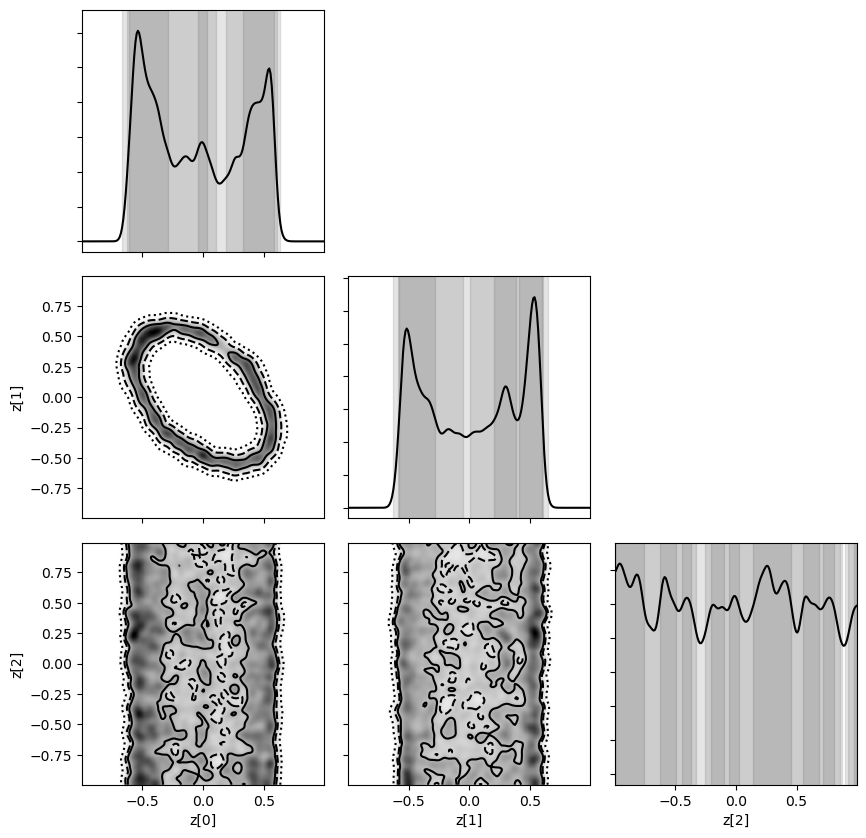

In [90]:
swyft.corner(predictions[1], ('z[0]', 'z[1]', 'z[2]'), labeler = None, bins = 200, smooth = 3);

In [91]:
A = swyft.Sample(x = torch.tensor(np.array([[x0]]).astype(np.float32)))
def loglike(u):
    B = swyft.Samples(z = torch.tensor(np.array([u]).astype(np.float32)))
    pred = network(A, B)
    lnL = pred[1].logratios.item()
    return lnL

def prior_transform(u):
    return u*2-1

ndim = 3

In [92]:
sampler = dynesty.NestedSampler(loglike, prior_transform, ndim,
                                       bound='multi', sample='rwalk', nlive = 1000)#, live_points = [u, v, logl])

In [93]:
sampler.run_nested(maxcall=100000, logl_max = -13)

473it [00:00, 876.08it/s, +1000 | bound: 0 | nc: 1 | ncall: 2598 | eff(%): 92.178 | loglstar:   -inf <  3.715 < -13.000 | logz:  0.438 +/-    nan | dlogz:  0.016 >  1.009]


-12.99407958984375 3.7150425910949707


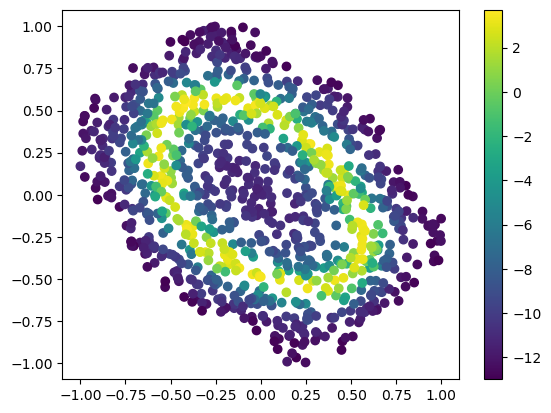

In [94]:
u = sampler.live_u
v = sampler.live_v
logl = sampler.live_logl
print(logl.min(), logl.max())
plt.scatter(v[:,0], v[:,1], c = logl)
plt.colorbar()

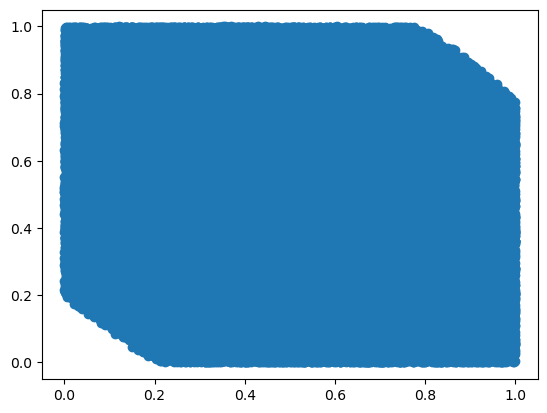

In [95]:
sampler.update()
p = np.array([sampler.propose_unif()[0] for _ in range(100000)])
plt.scatter(p[:,0], p[:,1])

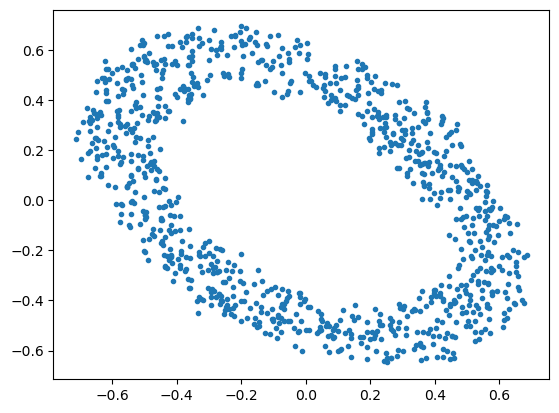

In [97]:
newp = np.array([sampler._new_point(-6)[0] for _ in range(10000)])
newv = newp*2-1
plt.scatter(newv[:,0], newv[:,1], marker='.')

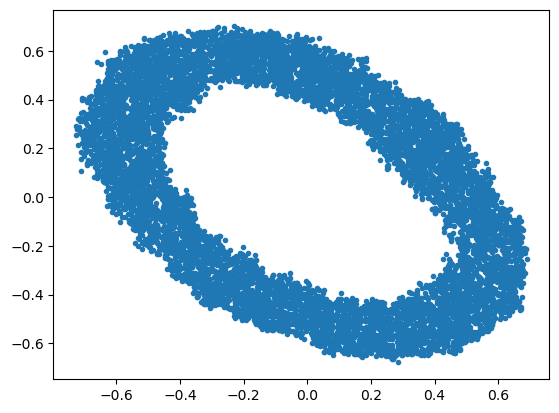

In [98]:
newp = np.array([sampler._new_point(-6)[0] for _ in range(10000)])
newv = newp*2-1
plt.scatter(newv[:,0], newv[:,1], marker='.')

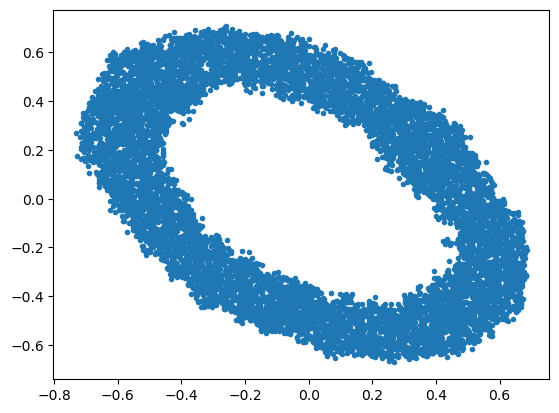

In [99]:
newp = np.array([sampler._new_point(-6)[0] for _ in range(10000)])
newv = newp*2-1
plt.scatter(newv[:,0], newv[:,1], marker='.')

In [55]:
#r(x; z) = p(z|x)/p(z) ~ 1 

In [ ]:
p(z_1, z_2|x) = p(z_1|x) * p(z_2|z_1, x)